In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:

import os 

_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

path_to_zip = tf.keras.utils.get_file('flower_photos', origin=_URL, untar=True, cache_dir=os.curdir)
PATH = os.path.join(os.path.dirname(path_to_zip), 'flower_photos')

228827136/228813984 [==============================] - 2s 0us/step


In [4]:
# Conferir o número total de imagens

import pathlib 

data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
# Construção e pré-processamento do Dataset a partir das imagens em disco
# Existem 5 pastas para cada uma das classes
# A informação nas pastas não está dividida em conjuntos de treino e validação
# Consultar detalhes na aula anterior e aqui: https://www.tensorflow.org/tutorials/load_data/images

batch_size = 32
IMG_SIZE = (180, 180)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
# Obter alguma informação sobre o dataset

#Cardinalidade 
print('Cardinalidade Treino: ', train_ds.cardinality().numpy())
print('Cardinalidade Validacão: ', val_ds.cardinality().numpy())

print('Classes: ', class_names)


# Explicar o valor obtido para a cardinalidade dos conjuntos 


Cardinalidade Treino:  92
Cardinalidade Validacão:  23
Classes:  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


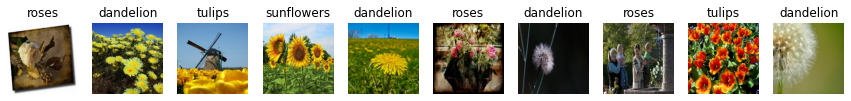

In [7]:
# Visualizar algumas imagens do Dataset
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].numpy().astype("float32")) #pode ser transformado num array numpy 
        plt.title(class_names[labels[i]])
        plt.axis("off")



In [19]:
# Criação de uma CNN
# Crie uma CNN sequencial utilizando a API funcional do Keras, não ultrapassando os 5 milhões de parâmetros
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://www.tensorflow.org/guide/keras/sequential_model
# https://keras.io/api/layers/

# O modelo final deve ter o nome model

#keras.backend.clear_session()
#tf.random.set_seed(42)
#np.random.seed(42)

# CRIAR NOVO MODELO chamado model utilizando a API funcional

inputs = keras.Input(shape=(180, 180, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(64, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(120, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(90, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(60, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [20]:
# Confirme se cumpriu o limite para o número de parâmteros especificado em cima

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 88, 88, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 44, 44, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 42, 42, 120)       6924

In [21]:
# Compilar o modelo
# Utilize o otimizador ADAM com parametrização default e a accuracy como métrica
# Defina a função de loss L que considerar mais apropriada

L = keras.losses.SparseCategoricalCrossentropy()

model.compile(loss=L, optimizer="adam", metrics=["accuracy"])

In [22]:
# Treinar o modelo durante 15 épocas 

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

# Começa a ocorrer o overffiting na epoch 6
# Poderia ser adicionado early-stoping

Epoch 1/15
92/92 [==============================] - 8s 79ms/step - loss: 1.5126 - accuracy: 0.3144 - val_loss: 1.2394 - val_accuracy: 0.4850
Epoch 2/15
92/92 [==============================] - 7s 77ms/step - loss: 1.3188 - accuracy: 0.4418 - val_loss: 1.1449 - val_accuracy: 0.5450
Epoch 3/15
92/92 [==============================] - 7s 78ms/step - loss: 1.1742 - accuracy: 0.5146 - val_loss: 1.0139 - val_accuracy: 0.6403
Epoch 4/15
92/92 [==============================] - 7s 78ms/step - loss: 1.0578 - accuracy: 0.5814 - val_loss: 0.9629 - val_accuracy: 0.6349
Epoch 5/15
92/92 [==============================] - 7s 79ms/step - loss: 0.9465 - accuracy: 0.6318 - val_loss: 0.8887 - val_accuracy: 0.6621
Epoch 6/15
92/92 [==============================] - 7s 78ms/step - loss: 0.8977 - accuracy: 0.6557 - val_loss: 0.8974 - val_accuracy: 0.6608
Epoch 7/15
92/92 [==============================] - 7s 77ms/step - loss: 0.8043 - accuracy: 0.6962 - val_loss: 0.8141 - val_accuracy: 0.6894
Epoch 8/15
92

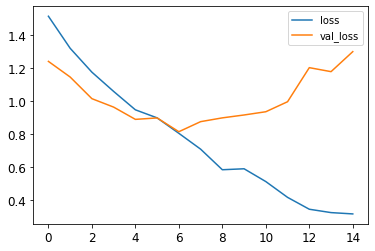

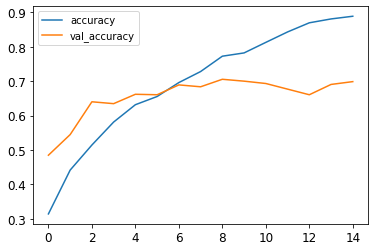

In [23]:
# Visualizar os resultados
# Visualização da evolução da accurary e da loss

import pandas as pd 
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();


In [24]:
# Adicionar Data Augmentation aos exemplos de treino para combater overfitting
# Consultar os links seguintes para obter detalhes: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
# https://www.tensorflow.org/tutorials/images/data_augmentation


data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(180, 180, 3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.5),
    keras.layers.experimental.preprocessing.RandomZoom(0.25),
])


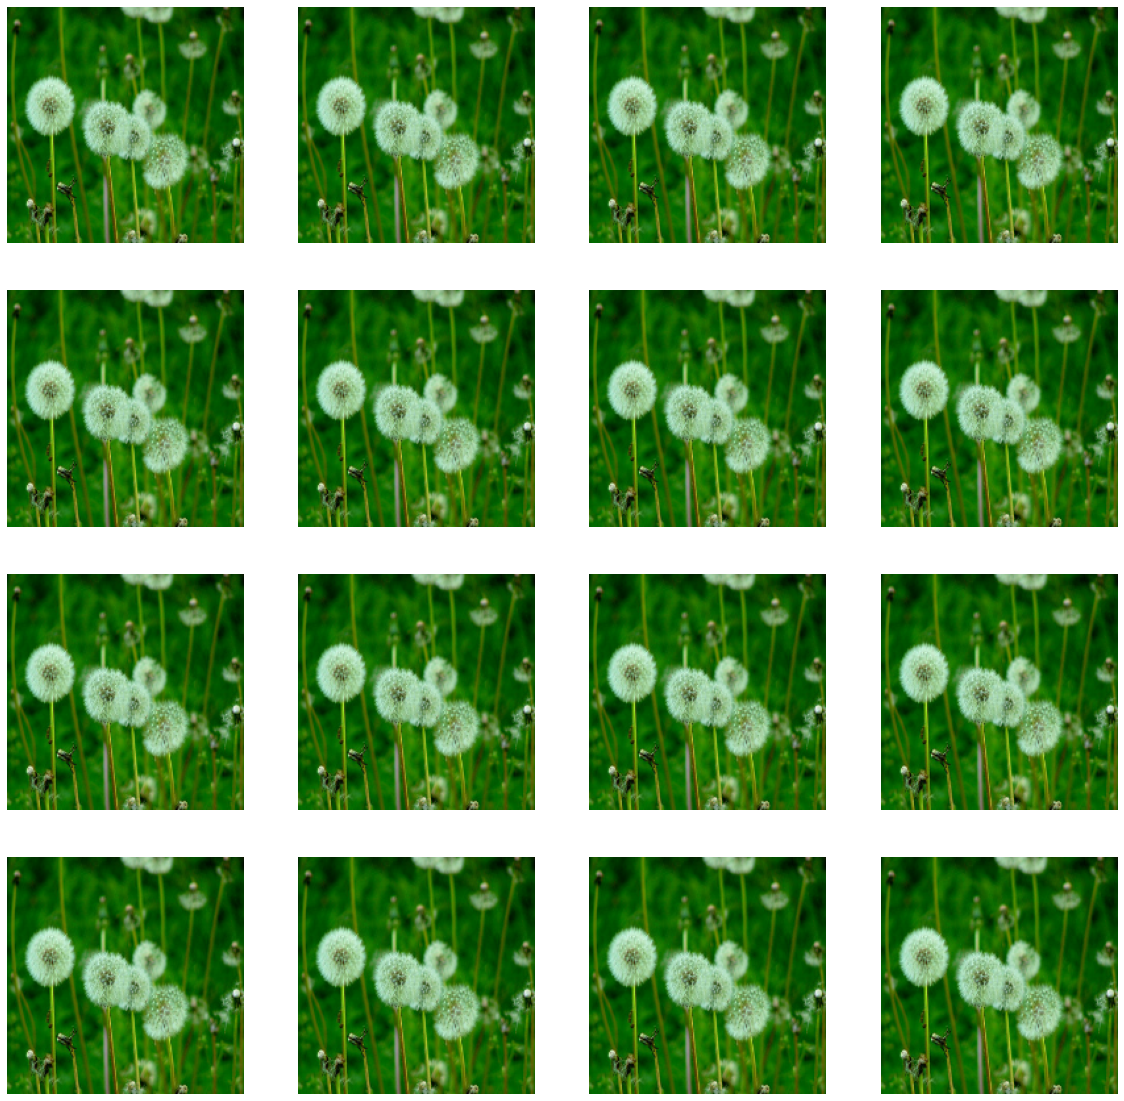

In [25]:
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("float32"))
    plt.axis("off")


In [26]:
# Criar modelo com a camada de Data Augmentation - Adicionar como primeira parte do modelo anterior


keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# O modelo chama-se modelA

inputs2 = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs2)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(64, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(120, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(90, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(60, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs2 = keras.layers.Dense(5, activation="softmax")(x)

modelA = keras.Model(inputs=inputs2, outputs=outputs2)

In [27]:
modelA.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 64)       0         
 2D)                                                         

In [31]:
# Compilar e treinar

L = keras.losses.SparseCategoricalCrossentropy()

modelA.compile(loss=L, optimizer="adam", metrics=["accuracy"])

history = modelA.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)


Epoch 1/25
92/92 [==============================] - 9s 86ms/step - loss: 0.7228 - accuracy: 0.7262 - val_loss: 0.7468 - val_accuracy: 0.6975
Epoch 2/25
92/92 [==============================] - 8s 84ms/step - loss: 0.7046 - accuracy: 0.7337 - val_loss: 0.6797 - val_accuracy: 0.7193
Epoch 3/25
92/92 [==============================] - 8s 84ms/step - loss: 0.7242 - accuracy: 0.7224 - val_loss: 0.6516 - val_accuracy: 0.7371
Epoch 4/25
92/92 [==============================] - 8s 84ms/step - loss: 0.7294 - accuracy: 0.7231 - val_loss: 0.7013 - val_accuracy: 0.7234
Epoch 5/25
92/92 [==============================] - 8s 84ms/step - loss: 0.7103 - accuracy: 0.7255 - val_loss: 0.7136 - val_accuracy: 0.7316
Epoch 6/25
92/92 [==============================] - 8s 85ms/step - loss: 0.7147 - accuracy: 0.7296 - val_loss: 0.6733 - val_accuracy: 0.7384
Epoch 7/25
92/92 [==============================] - 8s 84ms/step - loss: 0.6797 - accuracy: 0.7394 - val_loss: 0.6698 - val_accuracy: 0.7330
Epoch 8/25
92

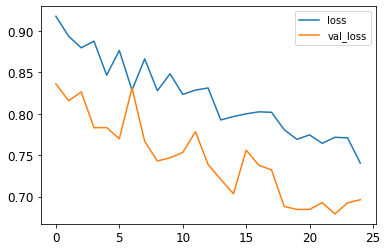

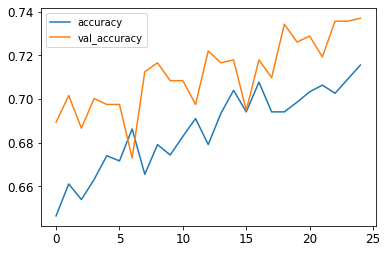

In [30]:

# Visualizar a analisar os resultados
# Visualização da evolução da accurary e da loss

import pandas as pd 
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()



In [ ]:
# Deixou de fazer overffiting
# Com mais epochs iria melhorar ainda mais os resultados

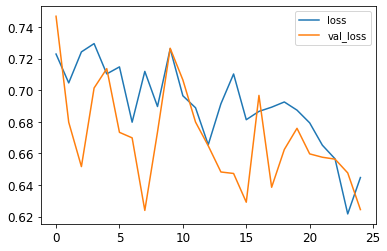

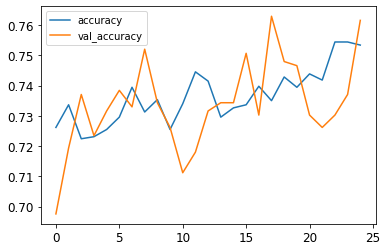

In [32]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()